In [2]:
print("ok")

ok


In [17]:

import requests
from langchain_core.runnables import RunnableLambda
from langchain_core.tools import Tool, tool
from langchain_openai import ChatOpenAI
from typing import TypedDict, List, Optional, Any,Annotated
from langchain.agents import AgentExecutor, create_openai_functions_agent
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode,tools_condition
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.graph import MessagesState,StateGraph, END, START
from langgraph.graph.message import add_messages

In [29]:
from IPython.display import display, Image


In [124]:
from dotenv import load_dotenv
load_dotenv(r"C:\Gajanan\data\Langchain\Langgraph\.env")

True

In [125]:
import os
WEATHER_API_KEY = os.getenv("WEATHER_API_KEY")
TAVILY_API_KEY = os.getenv("TAVILY_API_KEY")
TOGETHER_API_KEY = os.getenv("TOGETHER_API_KEY")
GOOGLE_API_KEY = os.getenv("GOOGLE_API_KEY")
HYPERCROWL_API_KEY = os.getenv("HYPERCROWL_API_KEY")
PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
OPENAI_API_KEY_LATEST = os.getenv("OPENAI_API_KEY")
MILVUS_USERNAME = os.getenv("MILVUS_USERNAME")
MILVUS_USERNAME_PASSWORD = os.getenv("MILVUS_USERNAME_PASSWORD")
MILVUS_URI = os.getenv("MILVUS_URI")
MILVUS_API_TOKEN = os.getenv("MILVUS_API_TOKEN")
GROQ_API_KEY = os.getenv("GROQ_API_KEY")
GOOGLE_SERP_API_KEY = os.getenv("GOOGLE_SERP_API_KEY")
OPEN_WEATHER_API_KEY = os.getenv("OPEN_WEATHER_API_KEY")
CURRENCY_EXVHAGE_API_KAY = os.getenv("CURRENCY_EXVHAGE_API_KAY")
RAPIDAPI_CURRENCY_MAP = os.getenv("RAPIDAPI_CURRENCY_MAP")
LANGSMITH_API_KEY  = os.getenv("LANGSMITH_API_KEY")
LANGSMITH_API_KEY  = os.getenv("LANGSMITH_API_KEY")
SERPER_API_KEY = os.getenv("SERPER_API_KEY")
PUSHOVER_USER_KEY = os.getenv("PUSHOVER_USER_KEY")
PUSHOVER_USER = os.getenv("PUSHOVER_USER")


In [128]:
LANGSMITH_TRACING=True
LANGSMITH_ENDPOINT="https://api.smith.langchain.com"
LANGSMITH_API_KEY=LANGSMITH_API_KEY
LANGSMITH_PROJECT="default"
OPENAI_API_KEY=OPENAI_API_KEY_LATEST

In [133]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI()
llm.invoke("Hello, world!")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 11, 'total_tokens': 20, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-BkWVe3J8eNTQYDdhe7yLPKylQl70C', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--40b6e4bf-a90b-4b42-b3e5-a471650ceb31-0', usage_metadata={'input_tokens': 11, 'output_tokens': 9, 'total_tokens': 20, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [76]:
import os
from langchain_community.utilities import GoogleSerperAPIWrapper

#os.environ["SERPER_API_KEY"] = ""

In [77]:
from langchain_community.utilities import GoogleSerperAPIWrapper
serper = GoogleSerperAPIWrapper()
#serper.run("What is the capital of India")

In [78]:
from langchain.agents import Tool
tool_search = Tool(name="search",
        func = serper.run,
        description = "Usefull for when you need more information from an online search")

In [79]:
tool_search.invoke("what is the capital of maharashtr?")

"Mumbai is the capital of Maharashtra due to its historical significance as a major trading port and its status as India's financial hub, housing key ... Mumbai also known as Bombay is the capital city of the Indian state of Maharashtra. Mumbai is the financial capital and the most populous city proper of ... Maharashtra's capital, Mumbai (formerly Bombay), is an island city on the western coast, connected to the mainland by roads and railways. Mumbai (also known as Bombay, the official name until 1995) is the capital city of the Indian state of Maharashtra. Mumbai lies on the Konkan coast on the west ... Mumbai is the capital of Maharashtra state. Hence, this is the correct option. - Option C: Nashik is a city in Maharashtra and an ancient city. It is one of the ... Mumbai, formerly Bombay, is a major city on the Arabian Sea, the capital of Maharashtra, and is a center of India's financial, commercial, and film industries. Maharashtra has two capitals – Mumbai and Nagpur. Mumbai is th

Pushover to push notification

In [80]:
pushover_url = "https://api.pushover.net/1/messages.json"

In [97]:
def push_nft(text:str):
    """Send a push notification to the user"""
    requests.post(pushover_url, data = {"token":PUSHOVER_USER_KEY,"user":PUSHOVER_USER,"message":text})

In [111]:
tool_push = Tool(name="send_push_notification",
                 func = push_nft,
                 description="usefull for when you want to send push notification")

#tool_push.invoke("Hello, me")

In [112]:
tools = [tool_search,tool_push]

In [113]:
class State(TypedDict):
    messages: Annotated[list,add_messages]

In [114]:
graph_builder = StateGraph(State)

In [115]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [116]:
llm_with_tools = llm.bind_tools(tools)

In [117]:
def chatbot(state:State):
    print("openai calling")
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

In [118]:
graph_builder.add_node("chatbot",chatbot)
graph_builder.add_node("tools",ToolNode(tools= tools))

In [119]:

graph_builder.add_conditional_edges("chatbot",tools_condition,"tools")
graph_builder.add_edge("tools","chatbot")
graph_builder.add_edge(START, "chatbot")

In [120]:
graph = graph_builder.compile()

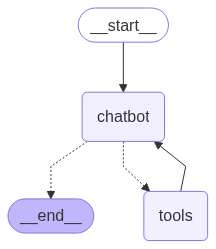

In [121]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [122]:
def chat(user_input:str, history):
    result = graph.invoke({"messages":[{"role":"user","content":user_input}]})
    return result["messages"][-1].content

In [ ]:
import gradio as gr
demo = gr.ChatInterface(fn=chat, type="messages")
demo.launch()

* Running on local URL:  http://127.0.0.1:7869
* To create a public link, set `share=True` in `launch()`.


openai calling
openai calling
openai calling
openai calling
openai calling
openai calling
